# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [3]:
# import libraries
import pyspark 
from pyspark import SparkConf 
from pyspark.sql import SparkSession

from pyspark.sql.functions import isnan, count, when, col, desc, udf, col 
from pyspark.sql.functions import sort_array, asc, avg
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import stddev as Fstddev
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import rank 
import pyspark.sql.functions as F
from pyspark.sql import DataFrameStatFunctions as statFunc
from pyspark.sql.functions import first
from pyspark.sql.functions import lit

# For Data Frames
import pandas as pd

#For Num Py Arrays
import numpy as np

#For Graps
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split# Split the data into training and testing sets
from sklearn.ensemble import RandomForestClassifier as RandomForestClass

In [5]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify Project").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
ls

mini_sparkify_event_data.json  Sparkify.ipynb  Sparkify-zh.ipynb


In [7]:
ls -h -l

total 123M
-rw-r--r-- 1 root root 123M Dec 15  2018 mini_sparkify_event_data.json
-rw-r--r-- 1 root root  26K Mar 25 16:13 Sparkify.ipynb
-rw-r--r-- 1 root root 4.8K Jul 31  2019 Sparkify-zh.ipynb


In [9]:
path = "./mini_sparkify_event_data.json"
sparkifyData = spark.read.json(path)

In [10]:
#For Viewing first 10 records
sparkifyData.take(10)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [11]:
#Print Schema
sparkifyData.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [14]:
#Add userId Column as a Primary Key
window = Window.orderBy(F.col('userId'))

sparkifyData = sparkifyData.withColumn('id', F.row_number().over(window))

In [15]:
#Drop Duplicate Rows & Show Top 10 Rows
sparkifyData.select("artist").dropDuplicates().sort("artist").show(n=10)

+--------------------+
|              artist|
+--------------------+
|                null|
|                 !!!|
|        & And Oceans|
|'N Sync/Phil Collins|
|        'Til Tuesday|
| 't Hof Van Commerce|
|'t Hof Van Commer...|
|       (Love) Tattoo|
|          (hed) p.e.|
|*NSYNC featuring ...|
+--------------------+
only showing top 10 rows



In [16]:
#Number of Rows in Dataframe
sparkifyData.count()

286500

In [17]:
sparkifyData.select("auth").dropDuplicates().sort("auth").show()

+----------+
|      auth|
+----------+
| Cancelled|
|     Guest|
| Logged In|
|Logged Out|
+----------+



In [18]:
sparkifyData.select("auth").groupBy("auth").agg({'auth' : 'count'}).withColumnRenamed('count(auth)', 'Authcount').sort(desc('Authcount')).show()

+----------+---------+
|      auth|Authcount|
+----------+---------+
| Logged In|   278102|
|Logged Out|     8249|
|     Guest|       97|
| Cancelled|       52|
+----------+---------+



In [19]:
#Show Top 10 Rows
sparkifyData.select("firstName").dropDuplicates().sort("firstName").show(n=10)

+----------+
| firstName|
+----------+
|      null|
|  Adelaida|
|    Adrian|
|   Adriana|
|    Adriel|
|   Ainsley|
|      Alex|
| Alexander|
|Alexandria|
|     Alexi|
+----------+
only showing top 10 rows



In [20]:
#Drop duplicates in Gender Columns
sparkifyData.select("gender").dropDuplicates().sort("gender").show()

+------+
|gender|
+------+
|  null|
|     F|
|     M|
+------+



In [21]:
#Total Sum of Values
sparkifyData.select("gender").groupBy("gender").agg({'gender' : 'count'}).withColumnRenamed('count(gender)', 'Gendercount').sort(desc('Gendercount')).show()

+------+-----------+
|gender|Gendercount|
+------+-----------+
|     F|     154578|
|     M|     123576|
|  null|          0|
+------+-----------+



In [22]:
sparkifyData.describe("itemInSession").show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201140994|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [23]:
#Show Top 10 Rows
sparkifyData.select("lastname").dropDuplicates().sort("lastname").show(n=10)

+---------+
| lastname|
+---------+
|     null|
|    Adams|
|  Aguilar|
|Alexander|
|    Allen|
| Atkinson|
|   Bailey|
|    Baker|
|     Ball|
|   Barnes|
+---------+
only showing top 10 rows



In [24]:
sparkifyData.describe('length').show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [25]:
sparkifyData.select(['auth', 'length', 'song']).where(sparkifyData["length"].isNull()).show(n=10)

+----------+------+----+
|      auth|length|song|
+----------+------+----+
| Logged In|  null|null|
| Logged In|  null|null|
| Logged In|  null|null|
| Logged In|  null|null|
| Logged In|  null|null|
| Logged In|  null|null|
| Logged In|  null|null|
| Logged In|  null|null|
| Logged In|  null|null|
|Logged Out|  null|null|
+----------+------+----+
only showing top 10 rows



In [26]:
sparkifyData.select("length").dropDuplicates().sort("length").show()

+--------+
|  length|
+--------+
|    null|
| 0.78322|
| 2.16771|
| 4.04853|
|  4.8322|
|  6.3473|
| 7.83628|
| 8.30649|
| 9.01179|
|10.03057|
|10.52689|
|11.20608|
|11.25832|
|11.36281|
|11.49342|
|11.54567|
|11.93751|
|11.98975|
|12.22485|
|12.30322|
+--------+
only showing top 20 rows



In [27]:
#Show Subscription Types
sparkifyData.select("level").dropDuplicates().sort("level").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [28]:
#Drop Duplicated in Location & Show Top 10 Rows
sparkifyData.select("location").dropDuplicates().sort("location").show(n=10)

+--------------------+
|            location|
+--------------------+
|                null|
|          Albany, OR|
|Albany-Schenectad...|
|      Alexandria, LA|
|Allentown-Bethleh...|
|       Anchorage, AK|
|Atlanta-Sandy Spr...|
|Atlantic City-Ham...|
|Austin-Round Rock...|
|     Bakersfield, CA|
+--------------------+
only showing top 10 rows



In [29]:
#Drop Duplicate Rows and Show the Method Values
sparkifyData.select("method").dropDuplicates().sort("method").show()

+------+
|method|
+------+
|   GET|
|   PUT|
+------+



In [30]:
#Show Top 10 Rows from page column
sparkifyData.select("page").dropDuplicates().sort("page").show(n=10)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
+--------------------+
only showing top 10 rows



In [31]:
#Drop Duplicate Rows & Show Top 10 from column registration
sparkifyData.select("registration").dropDuplicates().sort("registration").show(n=10)

+-------------+
| registration|
+-------------+
|         null|
|1521380675000|
|1526739206000|
|1526838391000|
|1528403713000|
|1528560242000|
|1528772084000|
|1528780738000|
|1529027541000|
|1529252604000|
+-------------+
only showing top 10 rows



In [32]:
sparkifyData.select(['auth', 'length', 'song', 'registration']).where(sparkifyData["registration"].isNull()).show(n=10)

+----------+------+----+------------+
|      auth|length|song|registration|
+----------+------+----+------------+
|Logged Out|  null|null|        null|
|Logged Out|  null|null|        null|
|Logged Out|  null|null|        null|
|Logged Out|  null|null|        null|
|Logged Out|  null|null|        null|
|Logged Out|  null|null|        null|
|Logged Out|  null|null|        null|
|Logged Out|  null|null|        null|
|Logged Out|  null|null|        null|
|Logged Out|  null|null|        null|
+----------+------+----+------------+
only showing top 10 rows



In [33]:
sparkifyData.describe("sessionId").show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [35]:
sparkifyData.select("sessionId").dropDuplicates().sort("sessionId").show(n=10)

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
+---------+
only showing top 10 rows



In [36]:
sparkifyData.select("song").dropDuplicates().sort("song").show(n=10)

+--------------------+
|                song|
+--------------------+
|                null|
|ÃÂg ÃÂtti Gr...|
| I Will Not Reap ...|
|              !@*$%#|
|#!*@ You Tonight ...|
|                  #1|
|#1 Fan [Feat. Key...|
|           #1 Stunna|
|                 #16|
| #18 (Album Version)|
+--------------------+
only showing top 10 rows



In [37]:
#Response Codes in Status Column
sparkifyData.select("status").dropDuplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [39]:
sparkifyData.select("status").groupBy("status").agg({'status' : 'count'}).withColumnRenamed('count(status)', 'Statuscount').sort(desc('Statuscount')).show()

+------+-----------+
|status|Statuscount|
+------+-----------+
|   200|     259812|
|   307|      26430|
|   404|        258|
+------+-----------+



In [40]:
#Top 10 Rows and This columns refers to Time Stamp
sparkifyData.select("ts").dropDuplicates().sort("ts").show(n=10)

+-------------+
|           ts|
+-------------+
|1538352117000|
|1538352180000|
|1538352394000|
|1538352416000|
|1538352676000|
|1538352678000|
|1538352886000|
|1538352899000|
|1538352905000|
|1538353084000|
+-------------+
only showing top 10 rows



In [42]:
sparkifyData.describe("ts").show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              286500|
|   mean|1.540956889810483...|
| stddev|1.5075439608226302E9|
|    min|       1538352117000|
|    max|       1543799476000|
+-------+--------------------+



In [43]:
sparkifyData.select("UserAgent").dropDuplicates().sort("UserAgent").show()

+--------------------+
|           UserAgent|
+--------------------+
|                null|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



In [44]:
sparkifyData.select(['auth', 'length', 'song', 'registration', 'UserAgent']).where(sparkifyData["UserAgent"].isNull()).show(n=10)

+----------+------+----+------------+---------+
|      auth|length|song|registration|UserAgent|
+----------+------+----+------------+---------+
|Logged Out|  null|null|        null|     null|
|Logged Out|  null|null|        null|     null|
|Logged Out|  null|null|        null|     null|
|Logged Out|  null|null|        null|     null|
|Logged Out|  null|null|        null|     null|
|Logged Out|  null|null|        null|     null|
|Logged Out|  null|null|        null|     null|
|Logged Out|  null|null|        null|     null|
|Logged Out|  null|null|        null|     null|
|Logged Out|  null|null|        null|     null|
+----------+------+----+------------+---------+
only showing top 10 rows



In [45]:
sparkifyData.select("userId").dropDuplicates().sort("userId").show(n=10)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows



In [46]:
#Total Users
sparkifyData.select("userId").dropDuplicates().count()

226

In [47]:
#Total Paid Users
sparkifyData.select(["userId", "level"]).filter(sparkifyData["level"] == "paid").select("userId").dropDuplicates().count()

166

In [48]:
#Free Users
sparkifyData.select(["userId", "level"]).filter(sparkifyData["level"] == "free").select("userId").dropDuplicates().count()

196

In [49]:
#Usage of Free and Paid Users
sparkifyData.select(["level"]).groupBy("level").agg({'level' : 'count'}).withColumnRenamed('count(level)', 'Levelcount').sort(desc('Levelcount')).show()

+-----+----------+
|level|Levelcount|
+-----+----------+
| paid|    228162|
| free|     58338|
+-----+----------+



In [50]:
#User which are on paid plan but also used free plan
sparkifyData.filter(sparkifyData["level"] == "paid").select("userId").dropDuplicates().intersect(sparkifyData.filter(sparkifyData["level"] == "free").select("userId").dropDuplicates()).count()

136

In [51]:
#Events associated with User Id 100003
sparkifyData.select(['page', 'userId', 'auth', 'status', 'song']).where(sparkifyData.userId == '100003').collect()

[Row(page='NextSong', userId='100003', auth='Logged In', status=200, song='Gone Going'),
 Row(page='NextSong', userId='100003', auth='Logged In', status=200, song='All We Know (Album Version)'),
 Row(page='NextSong', userId='100003', auth='Logged In', status=200, song='Heroes Of Faith'),
 Row(page='Help', userId='100003', auth='Logged In', status=200, song=None),
 Row(page='Home', userId='100003', auth='Logged In', status=200, song=None),
 Row(page='NextSong', userId='100003', auth='Logged In', status=200, song='Personal'),
 Row(page='NextSong', userId='100003', auth='Logged In', status=200, song='A Mess Of The Blues (1997 Digital Remaster) (Mono)'),
 Row(page='Add to Playlist', userId='100003', auth='Logged In', status=200, song=None),
 Row(page='NextSong', userId='100003', auth='Logged In', status=200, song='One I Love'),
 Row(page='Home', userId='100003', auth='Logged In', status=200, song=None),
 Row(page='NextSong', userId='100003', auth='Logged In', status=200, song='Two Doors Do

In [52]:
#Not Guest User
sparkifyData = sparkifyData.filter(sparkifyData["auth"] != "Guest")

In [53]:
sparkifyData.count()

286403

286500 - 286403 = 97 Observations removed

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [56]:
# Set value 1 if the user has cancelled the service otherwise 0.
churnEvent = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [57]:
sparkifyData = sparkifyData.withColumn("churn", churnEvent("page"))

In [58]:
userAggChurn = sparkifyData.select(["userId", "churn"]).groupBy("userId").agg(Fsum('churn').alias('sum'))

#Users have not cancelled the plan
userAggChurn.filter(userAggChurn["sum"] == 0).count()

174

In [59]:
#Users who cancelled the plan
userAggChurn.filter(userAggChurn["sum"] == 1).count()

52

In [60]:
#Users who cancelled the plan more than once
userAggChurn.filter(userAggChurn["sum"] > 1).count()

0

In [62]:
#Users that had cancelled the service and after that they returned to the service via Window function
churnedUsers = sparkifyData.filter(sparkifyData["churn"] == 1)
churnedUsers = churnedUsers.select("userId").dropDuplicates()
churnedUsers = churnedUsers.join(sparkifyData, on=['userId'], how="inner") 
churnedUsers = churnedUsers.select("userId", "ts", "churn")
windowval = Window.partitionBy("userId").orderBy(desc("ts"))
u = churnedUsers.select("userId", "ts", "churn", rank().over(windowval).alias("ranking"))
(u.filter(u["ranking"] == 1)).filter(u["churn"] == 0).show()

+------+-------------+-----+-------+
|userId|           ts|churn|ranking|
+------+-------------+-----+-------+
|   125|1539318918000|    0|      1|
+------+-------------+-----+-------+



In [63]:
sparkifyData.filter(sparkifyData["userId"] == 125).select(["id", "userId", "ts", "churn", "page"]).show(n=12)

+-----+------+-------------+-----+--------------------+
|   id|userId|           ts|churn|                page|
+-----+------+-------------+-----+--------------------+
|54661|   125|1539317144000|    0|            NextSong|
|54662|   125|1539317481000|    0|            NextSong|
|54663|   125|1539317711000|    0|            NextSong|
|54664|   125|1539317914000|    0|            NextSong|
|54665|   125|1539318124000|    0|            NextSong|
|54666|   125|1539318515000|    0|            NextSong|
|54667|   125|1539318728000|    0|            NextSong|
|54668|   125|1539318906000|    0|            NextSong|
|54669|   125|1539318917000|    0|         Roll Advert|
|54670|   125|1539318918000|    0|              Cancel|
|54671|   125|1539318918000|    1|Cancellation Conf...|
+-----+------+-------------+-----+--------------------+



In [64]:
median_fun = F.expr('percentile_approx(length, 0.5)')

length_data = sparkifyData.select(["userId", "length"]).filter(sparkifyData.length.isNotNull()).groupBy("userId").agg(median_fun.alias("median_length"),Fmin("length").alias("min_length"),Fmax("length").alias("max_length"),Fstddev("length").alias("stddev_length"))

length_data.select("median_length").summary().show()

+-------+------------------+
|summary|     median_length|
+-------+------------------+
|  count|               225|
|   mean|234.23559915555552|
| stddev| 4.051835569971286|
|    min|         213.60281|
|    25%|         232.61995|
|    50%|          234.1873|
|    75%|         236.09424|
|    max|         248.63302|
+-------+------------------+



In [65]:
page_data = sparkifyData.select(["userId", "page"]).groupBy(["userId", "page"]).agg({'page' : 'count'}).withColumnRenamed('count(page)', 'count')

# Reference 
# https://stackoverflow.com/questions/37486910/pivot-string-column-on-pyspark-dataframe

page_data = page_data.select(["userId", "page", "count"]).groupby("userId").pivot("page").agg(first("count")) 

page_data = page_data.fillna(0)

page_data.select("Add Friend").summary().show()

+-------+------------------+
|summary|        Add Friend|
+-------+------------------+
|  count|               226|
|   mean|18.924778761061948|
| stddev|20.574819695598585|
|    min|                 0|
|    25%|                 4|
|    50%|                13|
|    75%|                27|
|    max|               143|
+-------+------------------+



In [66]:
level_data = sparkifyData.select(["userId", "level"]).groupBy(["userId", "level"]).agg({'level' : 'count'}).withColumnRenamed('count(level)', 'count')

level_data = level_data.select(["userId", "level", "count"]).groupby("userId").pivot("level").agg(first("count")) 

level_data = level_data.fillna(0)

level_data.select("paid", "free").summary().show()

+-------+------------------+------------------+
|summary|              paid|              free|
+-------+------------------+------------------+
|  count|               226|               226|
|   mean| 1009.566371681416|257.70353982300884|
| stddev|1275.4176788704249|336.55119562453325|
|    min|                 0|                 0|
|    25%|                 0|                40|
|    50%|               541|               152|
|    75%|              1672|               345|
|    max|              7779|              2520|
+-------+------------------+------------------+



In [67]:
status_data = sparkifyData.select(["userId", "status"]).groupBy(["userId", "status"]).agg({'status' : 'count'}).withColumnRenamed('count(status)', 'count')

status_data = status_data.select(["userId", "status", "count"]).groupby("userId").pivot("status").agg(first("count")) 

status_data = status_data.fillna(0)

In [68]:
# Rename the Columns Function for better readability
def rename_columns(df, columns):
    
    """ Returns a PySpark dataframe with the name of columns changed. 
    
    Parameters:
        df (PySpark dataframe): the PySpark dataframe.  
        columns (dictionary): a dictionary with the name of columns to be changed.
        
    Returns: a PySpark with the name of the columns changed.
    """    
    
    
    if isinstance(columns, dict):
        for old_name, new_name in columns.items():
            df = df.withColumnRenamed(old_name, new_name)
        return df
    else:
        raise ValueError("'columns' should be a dict, like {'old_name_1':'new_name_1', 'old_name_2':'new_name_2'}")

In [69]:
#Rename Status Columns
status_data = rename_columns(status_data, {'200' : 'x200', '307' : 'x307', '404' : 'x404'})

#Show Summary
status_data.select("x200", "x307", "x404").summary().show()

+-------+------------------+------------------+------------------+
|summary|              x200|              x307|              x404|
+-------+------------------+------------------+------------------+
|  count|               226|               226|               226|
|   mean|1149.2079646017698|116.92477876106194|1.1371681415929205|
| stddev|1243.7113942205647| 236.4777811619607| 1.491826304471759|
|    min|                 6|                 0|                 0|
|    25%|               267|                25|                 0|
|    50%|               771|                70|                 1|
|    75%|              1725|               147|                 2|
|    max|              8909|              3241|                 7|
+-------+------------------+------------------+------------------+



In [70]:
gender_data = sparkifyData.select(["userId", "gender"]).distinct()

gender_data.select("gender").groupBy("gender").agg({'gender' : 'count'}).withColumnRenamed('count(gender)', 'Gendercount').show()

+------+-----------+
|gender|Gendercount|
+------+-----------+
|     F|        104|
|  null|          0|
|     M|        121|
+------+-----------+



In [71]:
churned_users = sparkifyData.select(["userId", "churn"]).filter(sparkifyData["churn"] == 1)

#Removed Churned users from active users
active_users = sparkifyData.filter(sparkifyData["churn"] == 0).select("userId").subtract(churned_users.select("userId"))

active_users = active_users.withColumn('churn', lit(0))

In [72]:
#Users who have canceled the service and those who not
label_data = active_users.union(churned_users)

In [73]:
#Join the information of the pyspark dataframes: label_data, length_data, page_data, level_data, and status_data.

processed_data = label_data.join(gender_data, on=['userId'], how="inner")

processed_data = processed_data.join(length_data, on=['userId'], how='inner')

processed_data = processed_data.join(page_data, on=['userId'], how='inner') 

processed_data = processed_data.join(level_data, on=['userId'], how='inner') 

processed_data = processed_data.join(status_data, on=['userId'], how='inner')

In [74]:
#Drop userId Column as it's no more useful
drop_list = ['userId']
processed_data = processed_data.select([column for column in processed_data.columns if column not in drop_list])

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [77]:
#Convert the data processed to Pandas
processedDataPd = processed_data.toPandas()

churnCount = processedDataPd["churn"].value_counts()

churnCount.index = ["Active Users", "Churned Users"]

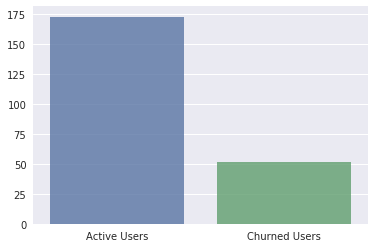

In [78]:
sns.barplot(churnCount.index, churnCount.values, alpha=0.8)

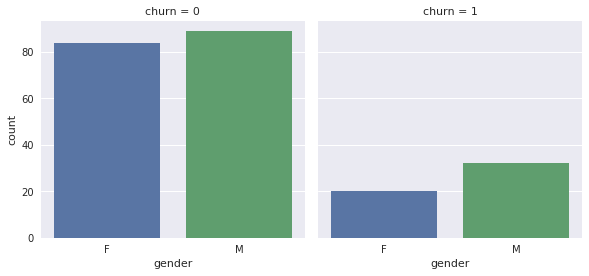

In [82]:
#Gender vs Churn
sns.factorplot("gender", col = "churn", col_wrap = 3,data = processedDataPd, kind = "count")
plt.show()

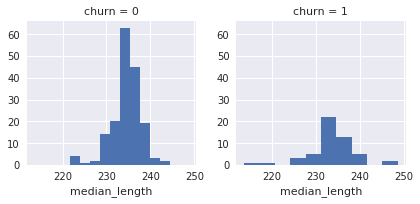

In [84]:
#Median Length vs Churn
median = sns.FacetGrid(processedDataPd, col="churn")
median = median.map(plt.hist, "median_length")

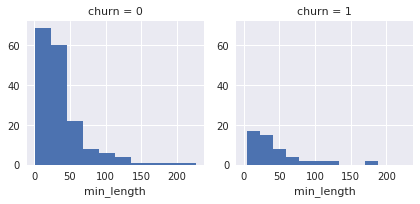

In [87]:
# Min Length vs Churn
mini = sns.FacetGrid(processedDataPd, col="churn")
mini = mini.map(plt.hist, "min_length")

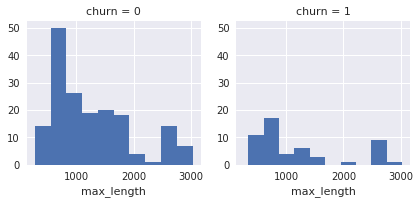

In [88]:
#Max Length vs Churn
maxl = sns.FacetGrid(processedDataPd, col="churn")
maxl = maxl.map(plt.hist, "max_length")

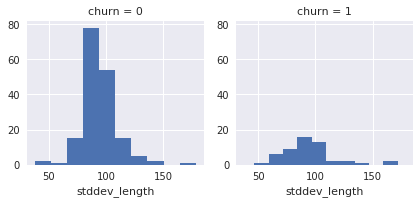

In [90]:
#Stddev Length vs Churn
stddev = sns.FacetGrid(processedDataPd, col="churn")
stddev = stddev.map(plt.hist, "stddev_length")

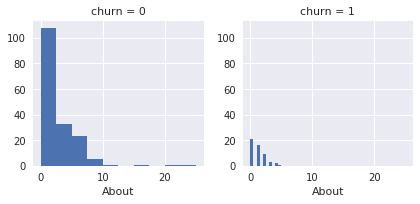

In [91]:
#About vs Churn
about = sns.FacetGrid(processedDataPd, col="churn")
about = about.map(plt.hist, "About")

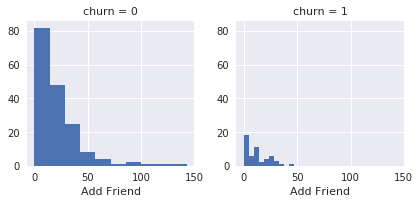

In [92]:
#Add Friend vs Churn
friend = sns.FacetGrid(processedDataPd, col="churn")
friend = friend.map(plt.hist, "Add Friend")

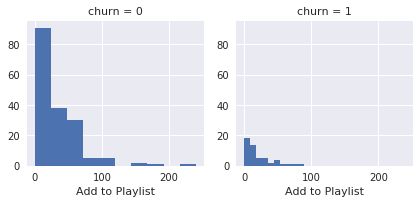

In [93]:
#Add to Playlist vs Churn
playlist = sns.FacetGrid(processedDataPd, col="churn")
playlist = playlist.map(plt.hist, "Add to Playlist")

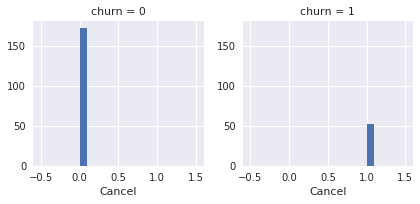

In [94]:
#Cancel vs Churn
cancel = sns.FacetGrid(processedDataPd, col="churn")
cancel = cancel.map(plt.hist, "Cancel")

#Exclude the variable Cancel because it will produce a data leakage.

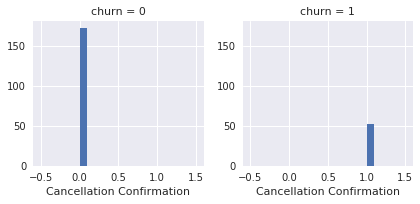

In [95]:
#Cancellation Confirmation  vs Churn
cancellation = sns.FacetGrid(processedDataPd, col="churn")
cancellation = cancellation.map(plt.hist, "Cancellation Confirmation")

#Exclude the variable Cancellation Confirmation because it will produce a data leakage.

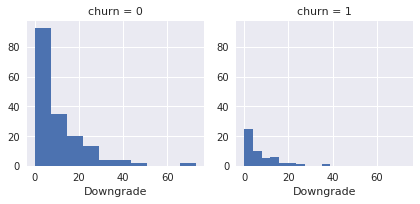

In [96]:
#Downgrade vs Churn
downgrade = sns.FacetGrid(processedDataPd, col="churn")
downgrade = downgrade.map(plt.hist, "Downgrade")

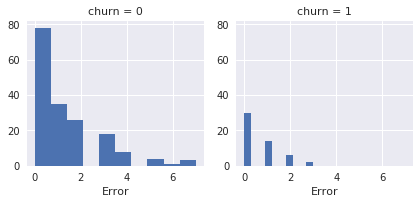

In [97]:
#Error vs Churn
error = sns.FacetGrid(processedDataPd, col="churn")
error = error.map(plt.hist, "Error")

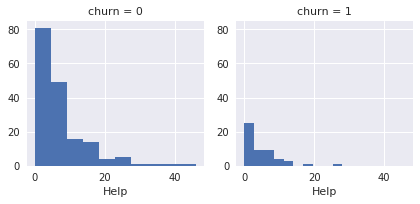

In [98]:
#Help vs Churn
help = sns.FacetGrid(processedDataPd, col="churn")
help = help.map(plt.hist, "Help")

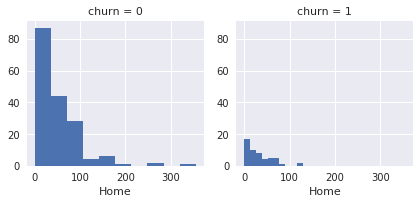

In [99]:
#Home vs Churn
home = sns.FacetGrid(processedDataPd, col="churn")
home = home.map(plt.hist, "Home")

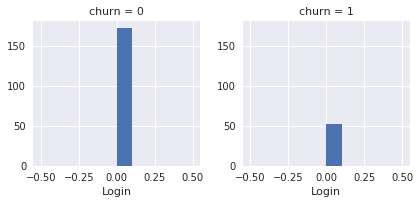

In [100]:
#Login vs Churn
login = sns.FacetGrid(processedDataPd, col="churn")
login = login.map(plt.hist, "Login")

In [101]:
processedDataPd["Login"].unique()

#We will exclude the Login variable as there is no variability in this variable.

array([0])

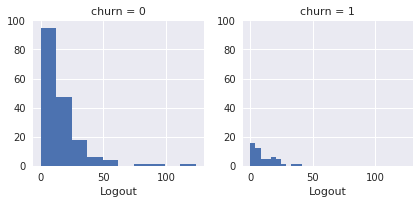

In [102]:
#Logout vs Churn
logout = sns.FacetGrid(processedDataPd, col="churn")
logout = logout.map(plt.hist, "Logout")

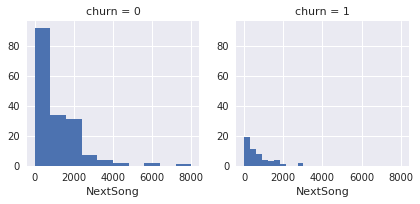

In [103]:
#NextSong vs Churn
nextSong = sns.FacetGrid(processedDataPd, col="churn")
nextSong = nextSong.map(plt.hist, "NextSong")

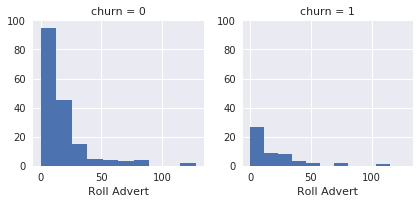

In [104]:
#Roll Advert vs Churn
rollAdvert = sns.FacetGrid(processedDataPd, col="churn")
rollAdvert = rollAdvert.map(plt.hist, "Roll Advert")

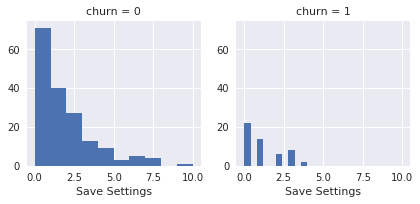

In [105]:
#Save Settings vs Churn
saveSettings = sns.FacetGrid(processedDataPd, col="churn")
saveSettings =saveSettings.map(plt.hist, "Save Settings")

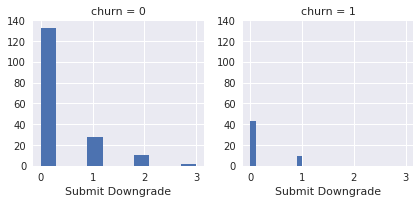

In [106]:
#Submit Downgrade vs Churn
submitDowngrade = sns.FacetGrid(processedDataPd, col="churn")
submitDowngrade = submitDowngrade.map(plt.hist, "Submit Downgrade")

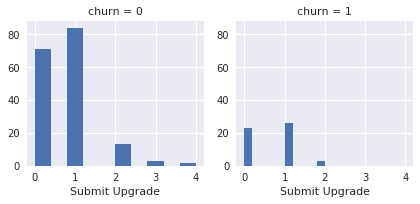

In [107]:
#Submit Upgrade vs Churn
submitUpgrade = sns.FacetGrid(processedDataPd, col="churn")
submitUpgrade = submitUpgrade.map(plt.hist, "Submit Upgrade")

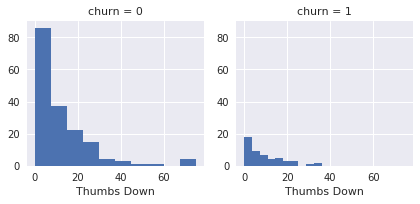

In [108]:
#Thumbs Down vs Churn
thumbsDown = sns.FacetGrid(processedDataPd, col="churn")
thumbsDown = thumbsDown.map(plt.hist, "Thumbs Down")

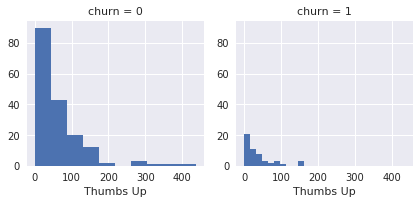

In [109]:
#Thumbs Up vs Churn
thumbsUp = sns.FacetGrid(processedDataPd, col="churn")
thumbsUp = thumbsUp.map(plt.hist, "Thumbs Up")

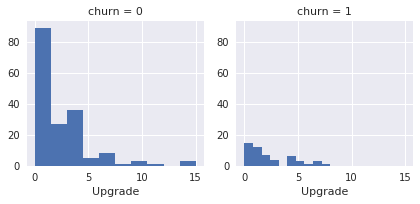

In [110]:
#Upgrade vs Churn
upgrade = sns.FacetGrid(processedDataPd, col="churn")
upgrade = upgrade.map(plt.hist, "Upgrade")

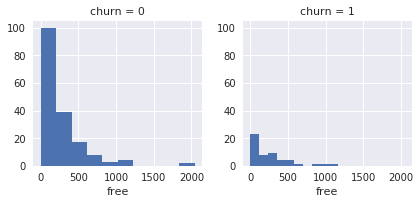

In [111]:
#Free users vs Churn
freeUsers  = sns.FacetGrid(processedDataPd, col="churn")
freeUsers = freeUsers.map(plt.hist, "free")

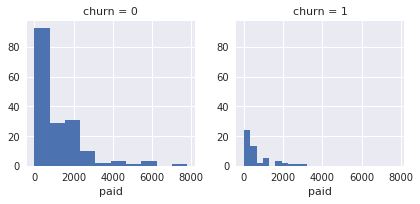

In [113]:
#Paid users vs Churn
paidUser  = sns.FacetGrid(processedDataPd, col="churn")
paidUser = paidUser.map(plt.hist, "paid")

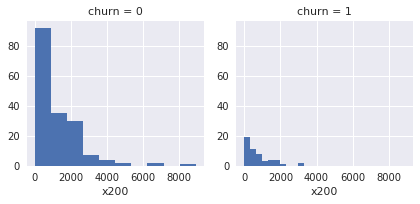

In [114]:
#Status Code = 200 (OK) vs Churn
status200  = sns.FacetGrid(processedDataPd, col="churn")
status200 = status200.map(plt.hist, "x200")

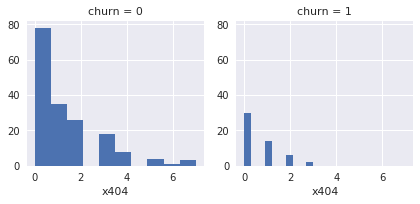

In [115]:
#Status Code = 404 (Page not found) vs Churn
status404  = sns.FacetGrid(processedDataPd, col="churn")
status404 = status404.map(plt.hist, "x404")

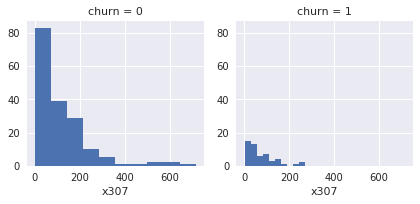

In [116]:
#Status Code = 307 (Temporary Redirect) vs Churn
status307  = sns.FacetGrid(processedDataPd, col="churn")
status307 = status307.map(plt.hist, "x307")

We will exclude the following variables: Cancel, Cancellation Confirmation, and Login. We will build a scatter plot matrix between each pair of numeric predictors.

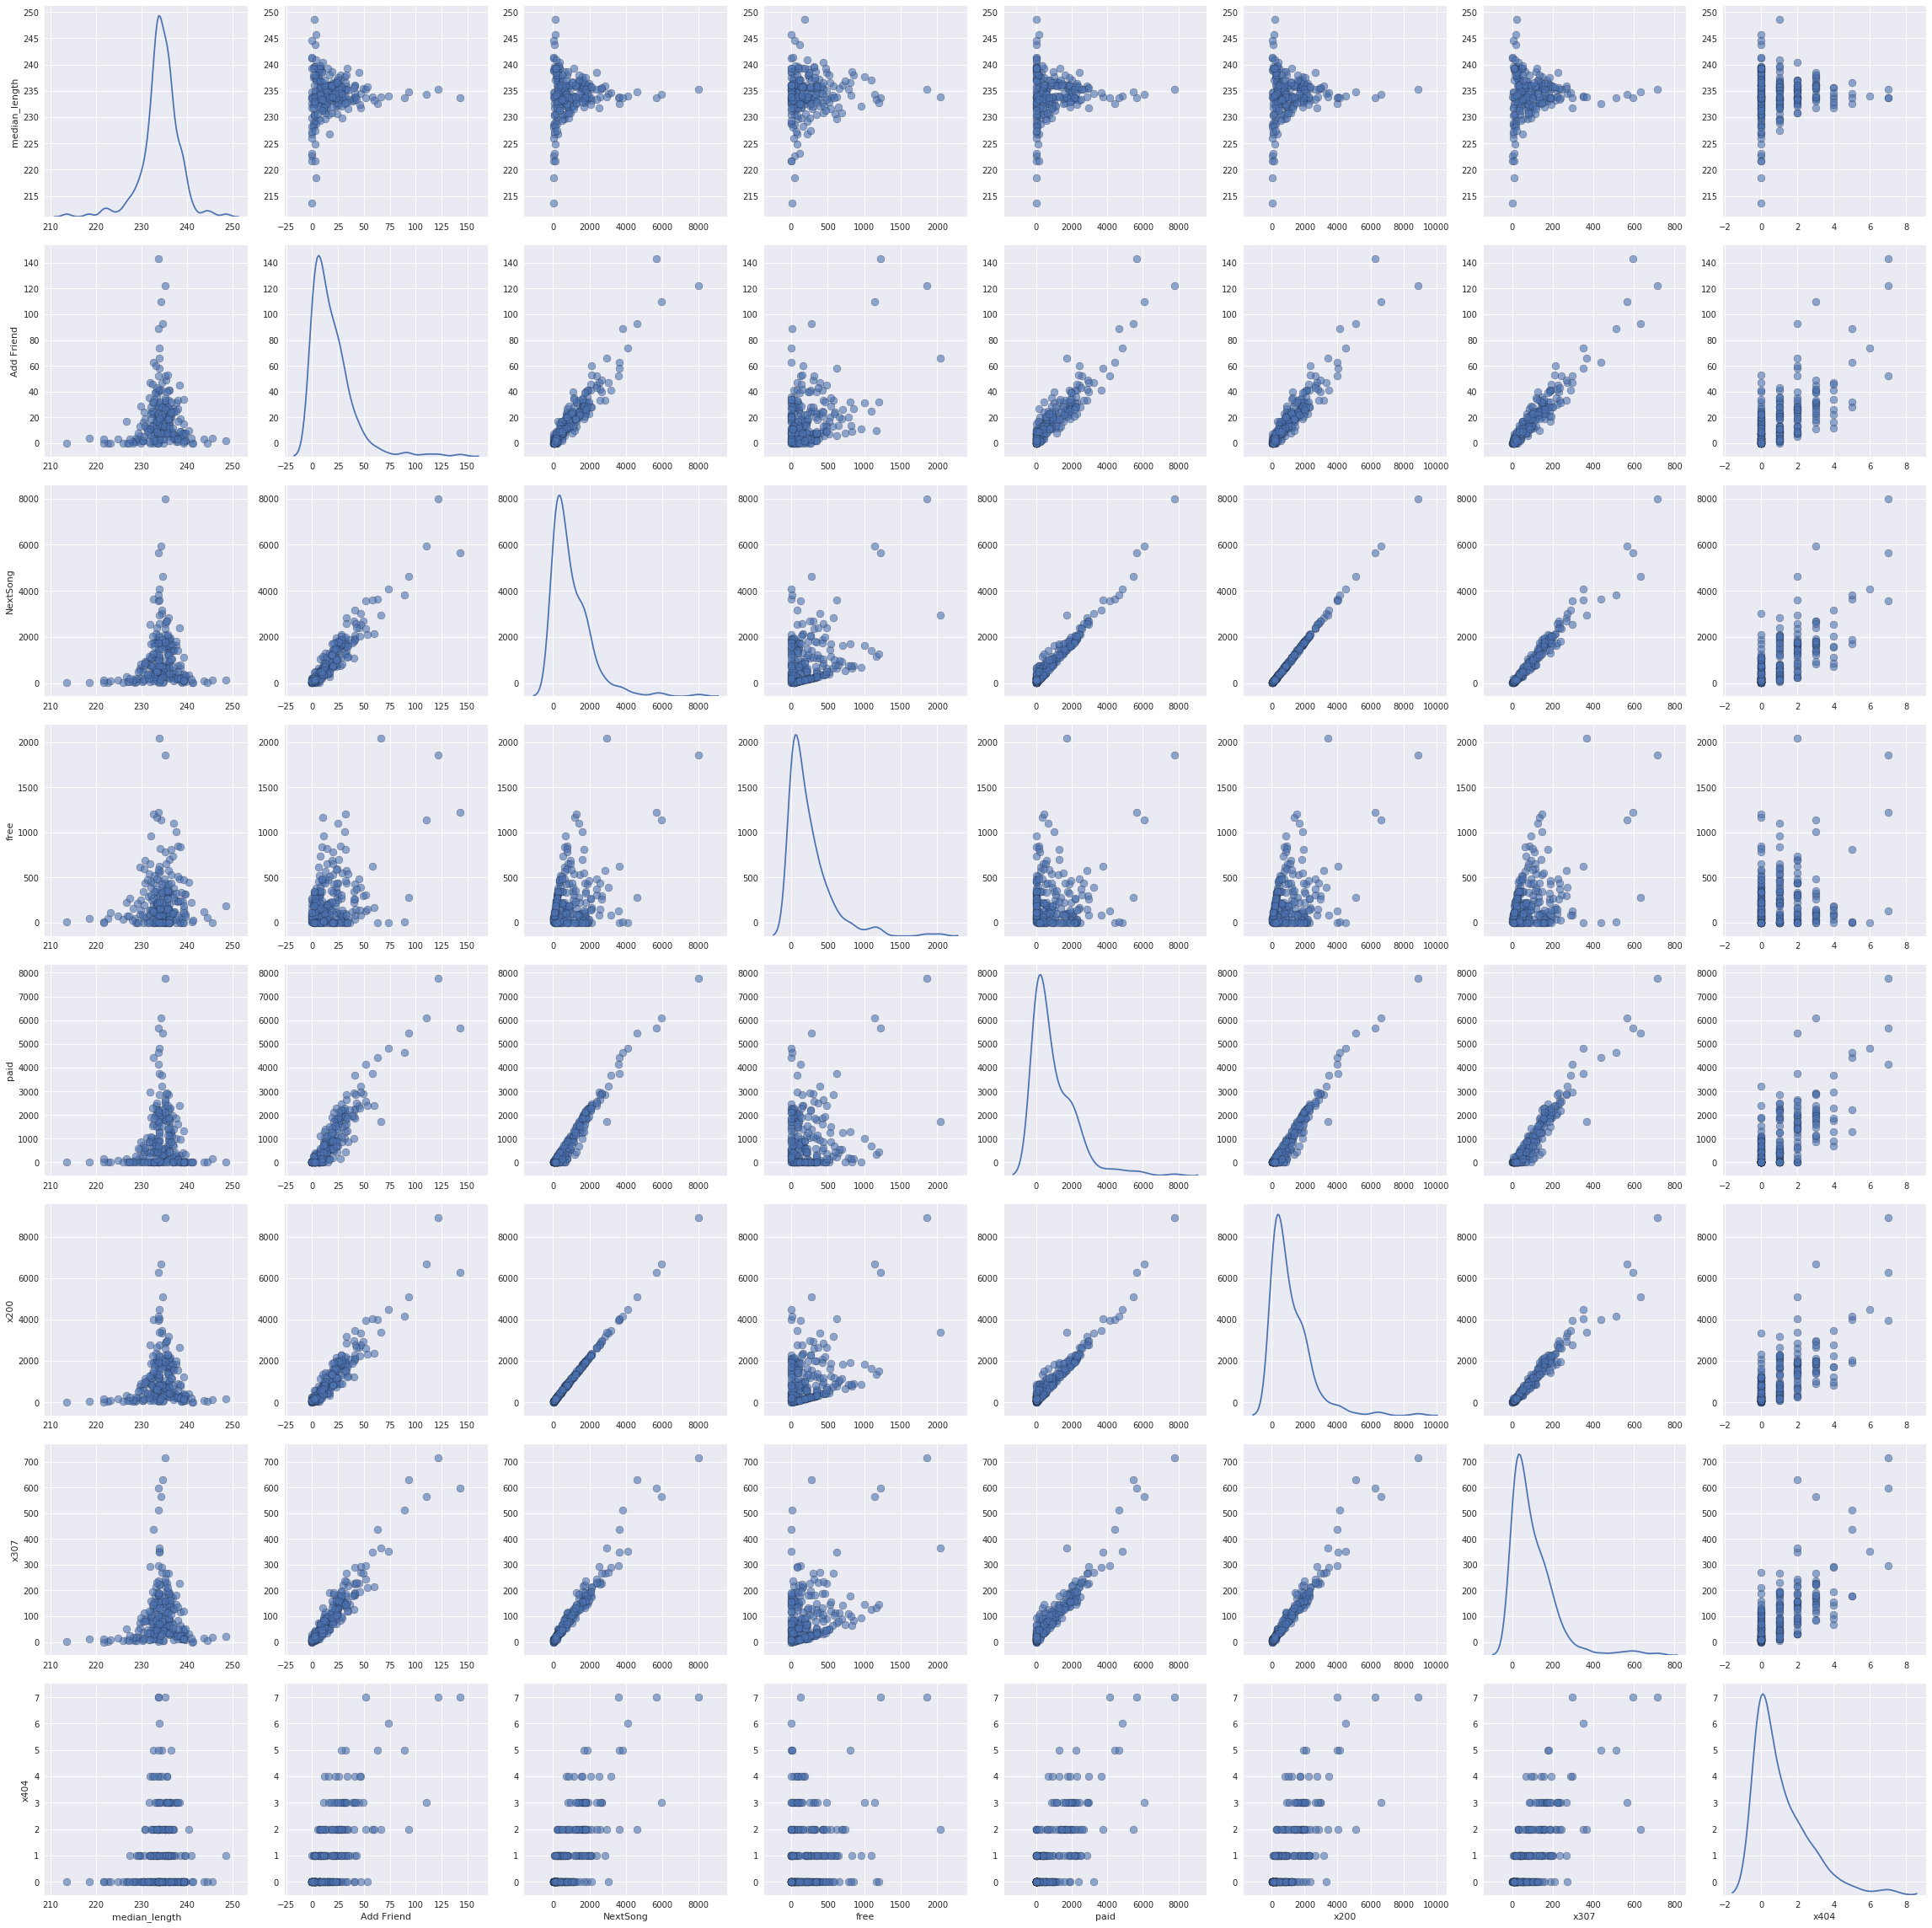

In [117]:
selectedPredictors = ['median_length', 'Add Friend', 'NextSong', 'free', 'paid', 'x200', 'x307', 'x404'               
]
sns.pairplot(processedDataPd[selectedPredictors], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             size = 4)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [119]:
dropList = ['Cancel', 'Cancellation Confirmation', 'Login' ]
processed_data = processed_data.select( \
     [column for column in processed_data.columns if column not in dropList])

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [120]:
#Prepare Data for Machine Learning
processed_data.select('churn').groupBy("churn").agg({'churn' : 'count'}).withColumnRenamed('count(churn)', 'Churncount').show()

+-----+----------+
|churn|Churncount|
+-----+----------+
|    1|        52|
|    0|       173|
+-----+----------+



In [122]:
processed_data = processed_data.sampleBy('churn', fractions={0: 52/225, 1: 1.0}).cache()

processed_data.select('churn').groupBy("churn").agg({'churn' : 'count'}).withColumnRenamed('count(churn)', 'Churncount').show()

+-----+----------+
|churn|Churncount|
+-----+----------+
|    1|        52|
|    0|         6|
+-----+----------+



In [123]:
#For Later Use
processed_data_pd = processed_data.toPandas()

In [125]:
#To treat the numeric and categorical variables in a proper way
cols = processed_data.columns

categoricalColumns = ['gender']

stages = [] 

for categoricalCol in categoricalColumns:    
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'churn', outputCol = 'label')
stages += [label_stringIdx]

In [126]:
numericCols = [ 'median_length', 'min_length', 'max_length', 
                'stddev_length','About', 'Add Friend','Add to Playlist',
                'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong',
                'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade',
                'Submit Upgrade', 'Thumbs Down','Thumbs Up', 'Upgrade','free',
                'paid', 'x200','x307', 'x404']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [127]:
# Use a random forest with default values as our base line model to make comparison with other models.
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=123)

stages += [rf]

In [128]:
{param[0].name: param[1] for param in rf.extractParamMap().items()}

{'probabilityCol': 'probability',
 'rawPredictionCol': 'rawPrediction',
 'seed': 123,
 'predictionCol': 'prediction',
 'labelCol': 'label',
 'featuresCol': 'features',
 'maxDepth': 5,
 'maxBins': 32,
 'minInstancesPerNode': 1,
 'minInfoGain': 0.0,
 'maxMemoryInMB': 256,
 'cacheNodeIds': False,
 'checkpointInterval': 10,
 'impurity': 'gini',
 'numTrees': 20,
 'featureSubsetStrategy': 'auto',
 'subsamplingRate': 1.0}

In [129]:
#To build the pipelines for random forest model
pipeline = Pipeline(stages=stages)

In [130]:
#Train Test Split
train, test = processed_data.randomSplit([0.9, 0.1], seed=123)

In [131]:
#Model Tunning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.probabilityCol,['probability']) \
    .addGrid(rf.rawPredictionCol,['rawPrediction']) \
    .addGrid(rf.seed,[123]) \
    .addGrid(rf.predictionCol,['prediction']) \
    .addGrid(rf.labelCol,['label']) \
    .addGrid(rf.featuresCol,['features']) \
    .addGrid(rf.maxDepth,[5]) \
    .addGrid(rf.maxBins,[32]) \
    .addGrid(rf.minInstancesPerNode,[1]) \
    .addGrid(rf.minInfoGain,[0.0]) \
    .addGrid(rf.maxMemoryInMB,[256]) \
    .addGrid(rf.checkpointInterval,[10]) \
    .addGrid(rf.impurity,['gini']) \
    .addGrid(rf.numTrees,[20]) \
    .addGrid(rf.featureSubsetStrategy,['auto']) \
    .addGrid(rf.subsamplingRate,[1.0]) \
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="accuracy"),
                          numFolds=3)

In [132]:
cvModel_m1 = crossval.fit(train)
cvModel_m1.avgMetrics

[0.8857195436142804]

In [133]:
# Evaluate accuracy in the training dataset
predictions = cvModel_m1.transform(train)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
acc = evaluator.evaluate(predictions)
print("Accuracy in the training dataset = %g" % (acc))

Accuracy in the training dataset = 1


In [134]:
#Removing some unnecessary predictors
cvModel_m1.bestModel.stages[-1].featureImportances

SparseVector(27, {0: 0.0303, 1: 0.086, 2: 0.0584, 3: 0.0188, 4: 0.009, 6: 0.1164, 7: 0.0582, 10: 0.0098, 11: 0.0947, 12: 0.0134, 13: 0.0025, 14: 0.0744, 15: 0.05, 16: 0.0904, 17: 0.0068, 19: 0.0439, 20: 0.0279, 21: 0.007, 22: 0.0675, 23: 0.0559, 24: 0.0413, 25: 0.0298, 26: 0.0076})

In [135]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    
    """ Returns a list of feature importances from a Random Forest model. 
    
    Parameters:
        featureImp (SparseVector): the feature importance.  
        dataset (pandas dataframe): the dataset as a pandas dataframe.
        featureCol (string): parameter related to the schema of the dataset variable.
        
        
    Returns: a dataframe with the feature importances from a random forest model
    """    
    
    
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [136]:
pipeline_model = pipeline.fit(train)

df = pipeline_model.transform(train)

In [137]:
ExtractFeatureImp(cvModel_m1.bestModel.stages[-1].featureImportances,df, "features").head(27)

,idx,name,score
5,6,Add Friend,0.116388
10,11,Home,0.094744
15,16,Settings,0.090440
0,1,median_length,0.086000
13,14,Roll Advert,0.074353
21,22,free,0.067518
1,2,min_length,0.058362
6,7,Add to Playlist,0.058176
22,23,paid,0.055851
14,15,Save Settings,0.049959


In [138]:
#Exclude variables with a value of importance below to 0.03
stages = [] 


label_stringIdx = StringIndexer(inputCol = 'churn', outputCol = 'label')
stages += [label_stringIdx]

numericCols = [ 'median_length', 'min_length', 'max_length', 
                'stddev_length', 'Add Friend','Add to Playlist',
                'Downgrade', 'Logout', 'NextSong',
                'Roll Advert', 'Save Settings', 'Settings',
                'Thumbs Down','free',
                'paid','x307']



assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=123)

stages += [rf]

In [139]:
pipeline = Pipeline(stages=stages)

In [140]:
# Fix the parameters of the base line model.

paramGrid = ParamGridBuilder() \
    .addGrid(rf.probabilityCol,['probability']) \
    .addGrid(rf.rawPredictionCol,['rawPrediction']) \
    .addGrid(rf.seed,[123]) \
    .addGrid(rf.predictionCol,['prediction']) \
    .addGrid(rf.labelCol,['label']) \
    .addGrid(rf.featuresCol,['features']) \
    .addGrid(rf.maxDepth,[5]) \
    .addGrid(rf.maxBins,[32]) \
    .addGrid(rf.minInstancesPerNode,[1]) \
    .addGrid(rf.minInfoGain,[0.0]) \
    .addGrid(rf.maxMemoryInMB,[256]) \
    .addGrid(rf.checkpointInterval,[10]) \
    .addGrid(rf.impurity,['gini']) \
    .addGrid(rf.numTrees,[20]) \
    .addGrid(rf.featureSubsetStrategy,['auto']) \
    .addGrid(rf.subsamplingRate,[1.0]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="accuracy"),
                          numFolds=3)

cvModel_m2 = crossval.fit(train)

cvModel_m2.avgMetrics

[0.8857195436142804]

In [141]:
# Evaluating accuracy in the training dataset
predictions = cvModel_m2.transform(train)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
acc = evaluator.evaluate(predictions)
print("Accuracy in the training dataset = %g" % (acc))

Accuracy in the training dataset = 0.981481


In [142]:
# Fix the parameters of the base line model.
paramGrid = ParamGridBuilder() \
    .addGrid(rf.probabilityCol,['probability']) \
    .addGrid(rf.rawPredictionCol,['rawPrediction']) \
    .addGrid(rf.seed,[123]) \
    .addGrid(rf.predictionCol,['prediction']) \
    .addGrid(rf.labelCol,['label']) \
    .addGrid(rf.featuresCol,['features']) \
    .addGrid(rf.maxDepth,[1,2,3,4,5]) \
    .addGrid(rf.maxBins,[32]) \
    .addGrid(rf.minInstancesPerNode,[1]) \
    .addGrid(rf.minInfoGain,[0.0]) \
    .addGrid(rf.maxMemoryInMB,[256]) \
    .addGrid(rf.checkpointInterval,[10]) \
    .addGrid(rf.impurity,['gini']) \
    .addGrid(rf.numTrees,[20]) \
    .addGrid(rf.featureSubsetStrategy,['auto']) \
    .addGrid(rf.subsamplingRate,[1.0]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="accuracy"),
                          numFolds=3)

cvModel_m3 = crossval.fit(train)

cvModel_m3.avgMetrics

[0.8857195436142804,
 0.8857195436142804,
 0.8857195436142804,
 0.8857195436142804,
 0.8857195436142804]

In [143]:
# Get the parameters of the best model using the previous grid
list(zip(cvModel_m3.avgMetrics, paramGrid))[0]

(0.8857195436142804,
 {Param(parent='RandomForestClassifier_c96c95d41571', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities.'): 'probability',
  Param(parent='RandomForestClassifier_c96c95d41571', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction',
  Param(parent='RandomForestClassifier_c96c95d41571', name='seed', doc='random seed.'): 123,
  Param(parent='RandomForestClassifier_c96c95d41571', name='predictionCol', doc='prediction column name.'): 'prediction',
  Param(parent='RandomForestClassifier_c96c95d41571', name='labelCol', doc='label column name.'): 'label',
  Param(parent='RandomForestClassifier_c96c95d41571', name='featuresCol', doc='features column name.'): 'features',
  Param(parent='RandomForestClassifier_c96c95d41571', name='maxDepth', doc='Maximu

In [144]:
# Evaluate accuracy in the training dataset
predictions = cvModel_m3.transform(train)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
acc = evaluator.evaluate(predictions)
print("Accuracy in the training dataset = %g" % (acc))

Accuracy in the training dataset = 0.888889


In [145]:
# Evaluate accuracy in the test dataset
predictions = cvModel_m3.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
acc = evaluator.evaluate(predictions)
print("Accuracy in the test dataset = %g" % (acc))

Accuracy in the test dataset = 1


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.